In [1]:
import antiCPy
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

2022-02-23 16:24:04.232993: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-23 16:24:04.233015: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
XAI = np.load("XAI_Finance.npy")
Names = np.load("Names.npy")
CorrMatrices = np.load("CorrMatricesTriangular.npy")
LabelNaiveOrdered = np.load("LabelNaiveOrdered.npy")
OptimalXAI = np.load("OptimalXAIFeature.npy")

In [3]:
clf = RandomForestClassifier(max_depth=20, random_state=0)

In [4]:
# 1 vs. all other clusters
print(OptimalXAI[0,:])

Label0 = (LabelNaiveOrdered == OptimalXAI[0,0])*1
print(Label0)

Data_0opt = CorrMatrices[:,OptimalXAI[0,1]]
Data_0opt = Data_0opt.reshape(-1,1)

# transform the imbalanced Data set
oversample = SMOTE()
Data_0opt, Label0 = oversample.fit_resample(Data_0opt, Label0)

X_train, X_test, y_train, y_test = train_test_split(Data_0opt, Label0,
                                                    test_size=0.5, random_state=1)
#X_train, y_train = oversample.fit_resample(X_train, y_train)

print(X_train.mean(), X_test.mean(), y_train.mean(), y_test.mean())

[0 4]
[1 1 0 ... 0 0 0]
0.396239044054196 0.3986700997138725 0.5062355658198614 0.49376443418013855


In [5]:
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
print(np.mean(y_hat))
np.mean(y_hat == y_test )

0.5309468822170901


0.6561200923787529

Optimal feature is 4


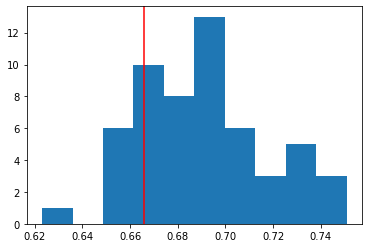

Optimal feature is 21


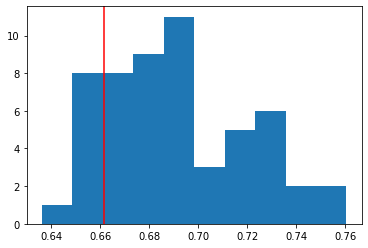

Optimal feature is 11


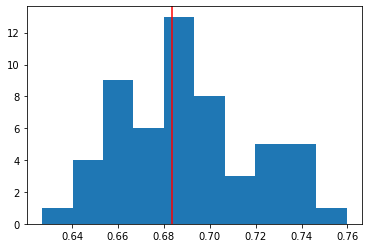

Optimal feature is 2


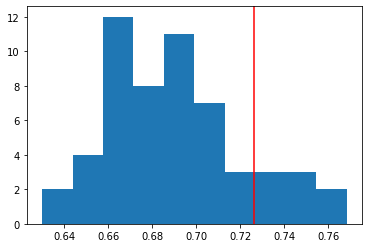

Optimal feature is 3


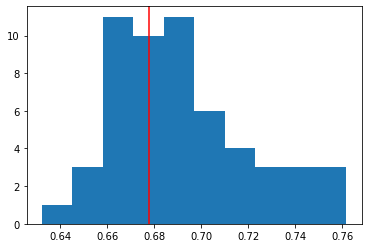

Optimal feature is 2


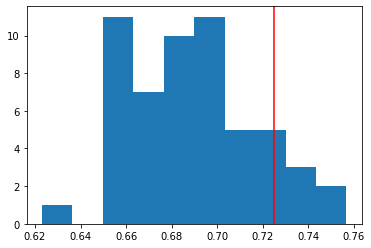

Optimal feature is 15


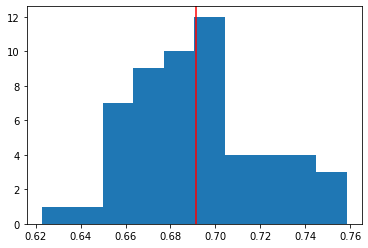

Optimal feature is 4


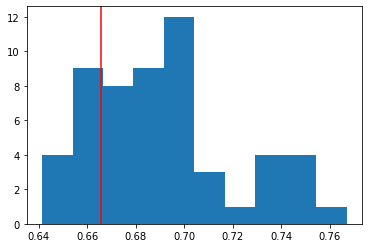

In [6]:
oversample = SMOTE()
for j in range(OptimalXAI.shape[0]):
    Scores = list()
    print("Optimal feature is", OptimalXAI[j,1])
    for i in range(CorrMatrices.shape[1]):
        Label0 = (LabelNaiveOrdered == OptimalXAI[0,0])*1
        Data_0 = CorrMatrices[:,i].reshape(-1,1)
        Data_0, Label0 = oversample.fit_resample(Data_0, Label0)
        X_train, X_test, y_train, y_test = train_test_split(Data_0, Label0,
                                                    test_size=0.5, random_state=1)
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        Scores.append( np.mean(y_hat == y_test ))
    plt.hist(Scores)
    plt.axvline(Scores[OptimalXAI[j,1]],c="red")
    plt.show()

### Train NN with all relevant features

For this, we need one-hot encoded y

In [7]:
print(set(OptimalXAI[:,1]))
CM_Reduced = CorrMatrices[:,list(set(OptimalXAI[:,1]))]
print(CM_Reduced.shape)

# one hot encoded
encoded_Y = np_utils.to_categorical(LabelNaiveOrdered)

X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.5, random_state=1)
print(encoded_Y)

# reverse the encoding via
# np.argmax(encoded_Y, 1)

{2, 3, 4, 11, 15, 21}
(5251, 6)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


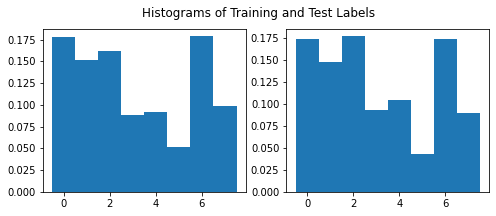

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(np.argmax(y_train,1), density = True,
         bins = np.arange(-0.5, max(np.argmax(y_train,1))+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Training and Test Labels")
plt.show()

In [9]:
n_In = CM_Reduced.shape[1]
num_classes = len(set(LabelNaiveOrdered))
print(n_In, num_classes)

model = keras.Sequential(
    [
        layers.Dense(units = 256, input_shape=(n_In,), activation = "selu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=1024,
              activation=keras.layers.LeakyReLU(alpha=0.05)),
        layers.Dense(units=128,
              activation=keras.layers.LeakyReLU(alpha=0.01)),
        layers.Dropout(0.3),
        layers.Dense(units =num_classes, activation="softmax"),
    ]
)
#model.build(n_In)
model.summary()

6 8
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1792      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1024)              132096    
                                                                 
 dense_4 (Dense)             (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 8)              

2022-02-23 16:27:53.107388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-23 16:27:53.107415: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-23 16:27:53.107431: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (BARDEEN): /proc/driver/nvidia/version does not exist
2022-02-23 16:27:53.107650: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
batch_size = 128
epochs = 100

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5)

Epoch 1/100
11/11 [==============================] - 1s 25ms/step - loss: 2.0566 - accuracy: 0.2180 - val_loss: 2.0355 - val_accuracy: 0.2490
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 2.0143 - accuracy: 0.2447 - val_loss: 1.9945 - val_accuracy: 0.2803
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.9635 - accuracy: 0.2614 - val_loss: 1.9394 - val_accuracy: 0.2704
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.8944 - accuracy: 0.2843 - val_loss: 1.8717 - val_accuracy: 0.2848
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 1.8302 - accuracy: 0.3262 - val_loss: 1.7943 - val_accuracy: 0.3298
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 1.7423 - accuracy: 0.3498 - val_loss: 1.7083 - val_accuracy: 0.3526
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 1.6723 - accuracy: 0.3697 - val_loss: 1.6339 - val_accuracy: 0.3465
Epoch 8/100


In [11]:
y_hat = np.argmax(model.predict(X_test),1)
np.mean(y_hat == np.argmax(y_test,1))

0.715917745620716

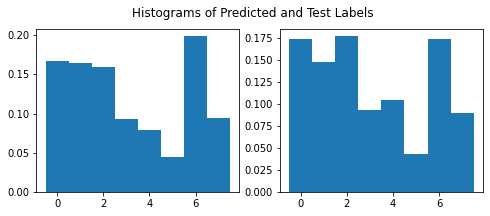

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(y_hat, density = True,
         bins = np.arange(-0.5, max(y_hat)+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Predicted and Test Labels")
plt.show()